<a href="https://colab.research.google.com/github/BDonadelli/Codigos-em-financas/blob/main/momentum_simples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
ticker="TGMA3"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
def strategy(returns, period=1, shorts=True):
    if shorts:
        position = returns.rolling(period).mean().map(lambda x: -1 if x <= 0 else 1)
    else:
        position = returns.rolling(period).mean().map(lambda x: 0 if x <= 0 else 1)
    performance = position.shift(1) * returns
    return performance

In [4]:
ticker = ticker+'.SA'
yfObj = yf.Ticker(ticker)
data = yfObj.history(start='2020-01-01', end='2023-12-31')

In [5]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-03:00,30.734557,31.983659,30.734557,31.827522,286100,0.0,0.0
2020-01-03 00:00:00-03:00,31.802870,32.682174,31.556336,32.583561,811900,0.0,0.0
2020-01-06 00:00:00-03:00,32.706823,32.772567,31.950787,32.378113,345200,0.0,0.0
2020-01-07 00:00:00-03:00,32.862958,32.862958,31.876823,32.337017,441100,0.0,0.0
2020-01-08 00:00:00-03:00,32.049396,32.854739,32.049396,32.468502,278500,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-11 00:00:00-03:00,27.520000,27.639999,27.200001,27.260000,149500,0.0,0.0
2023-12-12 00:00:00-03:00,27.510000,27.629999,26.660000,26.959999,370300,0.0,0.0
2023-12-13 00:00:00-03:00,26.940001,27.360001,26.680000,27.000000,504600,0.0,0.0


In [6]:
## log returns
returns = np.log(data['Close'])-np.log(data['Close'].shift(1))
returns = returns.dropna()
returns

Date
2020-01-03 00:00:00-03:00    0.023476
2020-01-06 00:00:00-03:00   -0.006325
2020-01-07 00:00:00-03:00   -0.001270
2020-01-08 00:00:00-03:00    0.004058
2020-01-09 00:00:00-03:00   -0.001013
                               ...   
2023-12-11 00:00:00-03:00   -0.009493
2023-12-12 00:00:00-03:00   -0.011066
2023-12-13 00:00:00-03:00    0.001483
2023-12-14 00:00:00-03:00   -0.003711
2023-12-15 00:00:00-03:00    0.005561
Name: Close, Length: 984, dtype: float64

In [7]:
performance = strategy(returns, period=1).dropna()
performance

Date
2020-01-06 00:00:00-03:00   -0.006325
2020-01-07 00:00:00-03:00    0.001270
2020-01-08 00:00:00-03:00   -0.004058
2020-01-09 00:00:00-03:00   -0.001013
2020-01-10 00:00:00-03:00   -0.015586
                               ...   
2023-12-11 00:00:00-03:00    0.009493
2023-12-12 00:00:00-03:00    0.011066
2023-12-13 00:00:00-03:00   -0.001483
2023-12-14 00:00:00-03:00   -0.003711
2023-12-15 00:00:00-03:00   -0.005561
Name: Close, Length: 983, dtype: float64

In [11]:
years = (performance.index.max() - performance.index.min()).days / 365
perf_cum = np.exp(performance.cumsum())
tot = perf_cum.iloc[-1] - 1
ann = perf_cum.iloc[-1] ** (1 / years) - 1
vol = performance.std() * np.sqrt(252)
rfr = 0.1315
sharpe = (ann - rfr) / vol
print(f"1-day TSM Strategy yields:" +
      f"\n\t{tot*100:.2f}% total returns" +
      f"\n\t{ann*100:.2f}% annual returns" +
      f"\n\t{sharpe:.2f} Sharpe Ratio")


1-day TSM Strategy yields:
	-11.70% total returns
	-3.11% annual returns
	-0.33 Sharpe Ratio


In [12]:
ret = np.exp(returns.cumsum())
b_tot = ret.iloc[-1] - 1
b_ann = ret.iloc[-1] ** (1 / years) - 1
b_vol = returns.std() * np.sqrt(252)
b_sharpe = (b_ann - rfr) / b_vol
print(f"Baseline Buy-and-Hold Strategy yields:" +
      f"\n\t{b_tot*100:.2f}% total returns" +
      f"\n\t{b_ann*100:.2f}% annual returns" +
      f"\n\t{b_sharpe:.2f} Sharpe Ratio")

Baseline Buy-and-Hold Strategy yields:
	-15.01% total returns
	-4.04% annual returns
	-0.35 Sharpe Ratio


/tmp/ipykernel_40737/3744807380.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  perf_dict['tot_ret'][p] = (perf[-1] - 1)
/tmp/ipykernel_40737/3744807380.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ann = (perf[-1] ** (1/years) - 1)


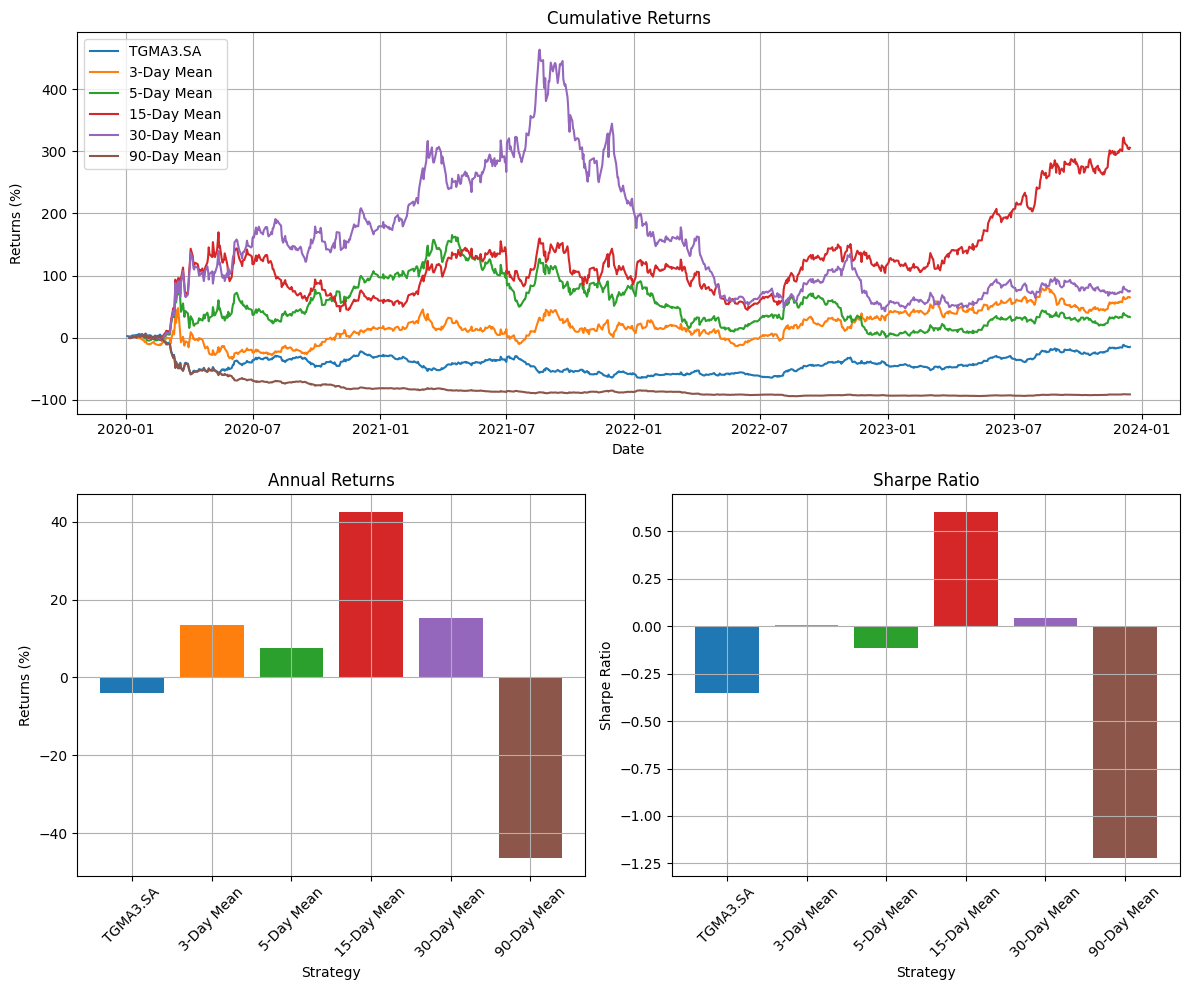

In [10]:
# run  model in a loop with 3, 5, 15, 30, and 90-day time periods.
import matplotlib.gridspec as gridspec
periods = [3, 5, 15, 30, 90]
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 4)
ax0 = fig.add_subplot(gs[:2, :4])
ax1 = fig.add_subplot(gs[2:, :2])
ax2 = fig.add_subplot(gs[2:, 2:])
ax0.plot((np.exp(returns.cumsum()) - 1) * 100, label=ticker, linestyle='-')
perf_dict = {'tot_ret': {'buy_and_hold': (np.exp(returns.sum()) - 1)}}
perf_dict['ann_ret'] = {'buy_and_hold': b_ann}
perf_dict['sharpe'] = {'buy_and_hold': b_sharpe}
for p in periods:
    log_perf = strategy(returns, period=p )
    perf = np.exp(log_perf.cumsum())
    perf_dict['tot_ret'][p] = (perf[-1] - 1)
    ann = (perf[-1] ** (1/years) - 1)
    perf_dict['ann_ret'][p] = ann
    vol = log_perf.std() * np.sqrt(252)
    perf_dict['sharpe'][p] = (ann - rfr) / vol
    ax0.plot((perf - 1) * 100, label=f'{p}-Day Mean')

ax0.set_ylabel('Returns (%)')
ax0.set_xlabel('Date')
ax0.set_title('Cumulative Returns')
ax0.grid()
ax0.legend()
_ = [ax1.bar(i, v * 100) for i, v in enumerate(perf_dict['ann_ret'].values())]
ax1.set_xticks([i for i, k in enumerate(perf_dict['ann_ret'])])
ax1.set_xticklabels([f'{k}-Day Mean'
    if type(k) is int else ticker for
    k in perf_dict['ann_ret'].keys()],
    rotation=45)
ax1.grid()
ax1.set_ylabel('Returns (%)')
ax1.set_xlabel('Strategy')
ax1.set_title('Annual Returns')
_ = [ax2.bar(i, v) for i, v in enumerate(perf_dict['sharpe'].values())]
ax2.set_xticks([i for i, k in enumerate(perf_dict['sharpe'])])
ax2.set_xticklabels([f'{k}-Day Mean'
    if type(k) is int else ticker for
    k in perf_dict['sharpe'].keys()],
    rotation=45)
ax2.grid()
ax2.set_ylabel('Sharpe Ratio')
ax2.set_xlabel('Strategy')
ax2.set_title('Sharpe Ratio')
plt.tight_layout()
plt.show()